# Realtion between unemployment rates and safety needs

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from helpers import *
import plotly.express as px
from datetime import datetime
import statsmodels.formula.api as smf
import re


In [11]:
#import data
dfeu = pd.read_csv('DATA/eu.tsv',sep='\t')
countries = pd.read_csv('DATA/countries_list.csv.xls')


In [12]:
dfts=process_eu_unemployment(dfeu,countries)

In [114]:
dfts=dfts[~(dfts['Country'].isin(['United States','Japan','Turkey']))]
dfts

,Country,age,unit,sex,Country_code,Date,Value,Year,Month
0,Austria,TOTAL,PC_ACT,F,AT,2020-07-01,4.5,2020,7
1,Austria,TOTAL,PC_ACT,M,AT,2020-07-01,5.8,2020,7
2,Austria,TOTAL,PC_ACT,T,AT,2020-07-01,5.2,2020,7
3,Austria,TOTAL,THS_PER,F,AT,2020-07-01,96.0,2020,7
4,Austria,TOTAL,THS_PER,M,AT,2020-07-01,142.0,2020,7
...,...,...,...,...,...,...,...,...,...
18230,United Kingdom,Y_LT25,PC_ACT,M,UK,2018-01-01,12.7,2018,1
18231,United Kingdom,Y_LT25,PC_ACT,T,UK,2018-01-01,11.9,2018,1
18232,United Kingdom,Y_LT25,THS_PER,F,UK,2018-01-01,228.0,2018,1
18233,United Kingdom,Y_LT25,THS_PER,M,UK,2018-01-01,279.0,2018,1


In [124]:
len(dfts['Country'].unique()[:-3])

28

## General look over all EU data

The following methods helps us to put everything in perspective by plotting the evolution of the percentages of unemployed people

In [158]:
## General pipeline for processing the aforementionned data
def unemployment_across_groups(dfts,test_group,size=(12,18)):
    #devide dataset between different metrics
    df_percentage=dfts[dfts['unit']=='PC_ACT'].drop(columns='unit').copy()
    df_numeric=dfts[~(dfts['unit']=='PC_ACT')].drop(columns='unit').copy()
    #compile data needed for graph generation
    generals=[df_percentage,df_numeric]
    ylabels=['Unemployment Percentage','Unemployed People (x1000)']
    #Generate plot with two pannels 
    fig,axs=plt.subplots(2,1,figsize=size)
    #Iterate over each metric dataset
    results=[]
    for i in range(len(generals)):
        #Select metric
        df=generals[i]
        #Aggregate by testing group and Date to get monthly mean 
        df_agg=df.groupby([test_group,'Date']).mean(numeric_only=True)['Value'].copy()
        #'Flatten' the indeces to get only one index column corresponding to the testing group
        df_agg=df_agg.reset_index(level='Date')
        #Plot the different lines for each of the testing group elements
        for idx in df_agg.index.unique(): 
            axs[i].plot(df_agg.loc[idx]['Date'],df_agg.loc[idx]['Value'],label=idx)
        #Add details to the plot
        axs[i].axvline(x=datetime(2020,3,1),color='red', linestyle='--', label='Lockdown')
        axs[i].legend(loc='upper left')
        axs[i].set_xlabel('Date')
        axs[i].set_ylabel(ylabels[i])
        axs[i].set_title(f'{ylabels[i]} per {test_group} across Europe')
        results.append(df_agg)
    plt.show()
    return results

### Distribution amongst age groups

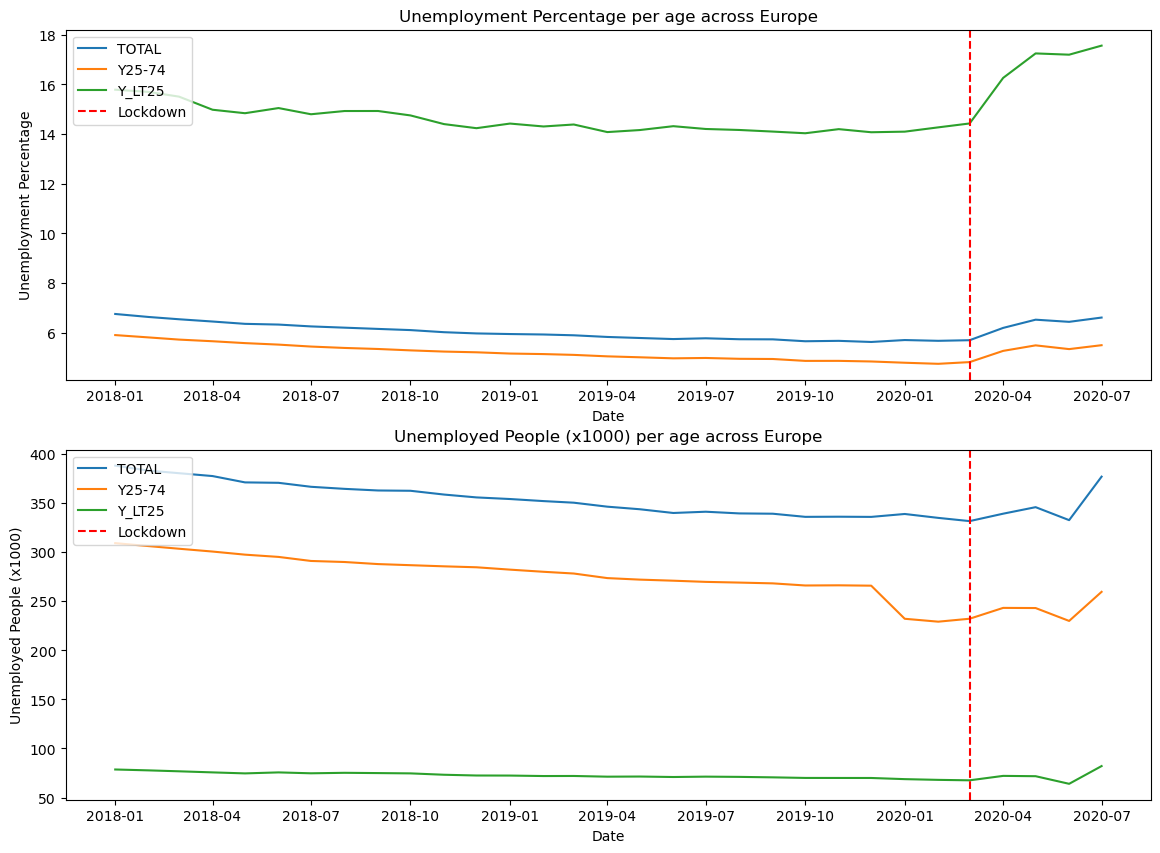

In [159]:
res_age=unemployment_across_groups(dfts,'age',(14,10))

### Distribution amongst sexes

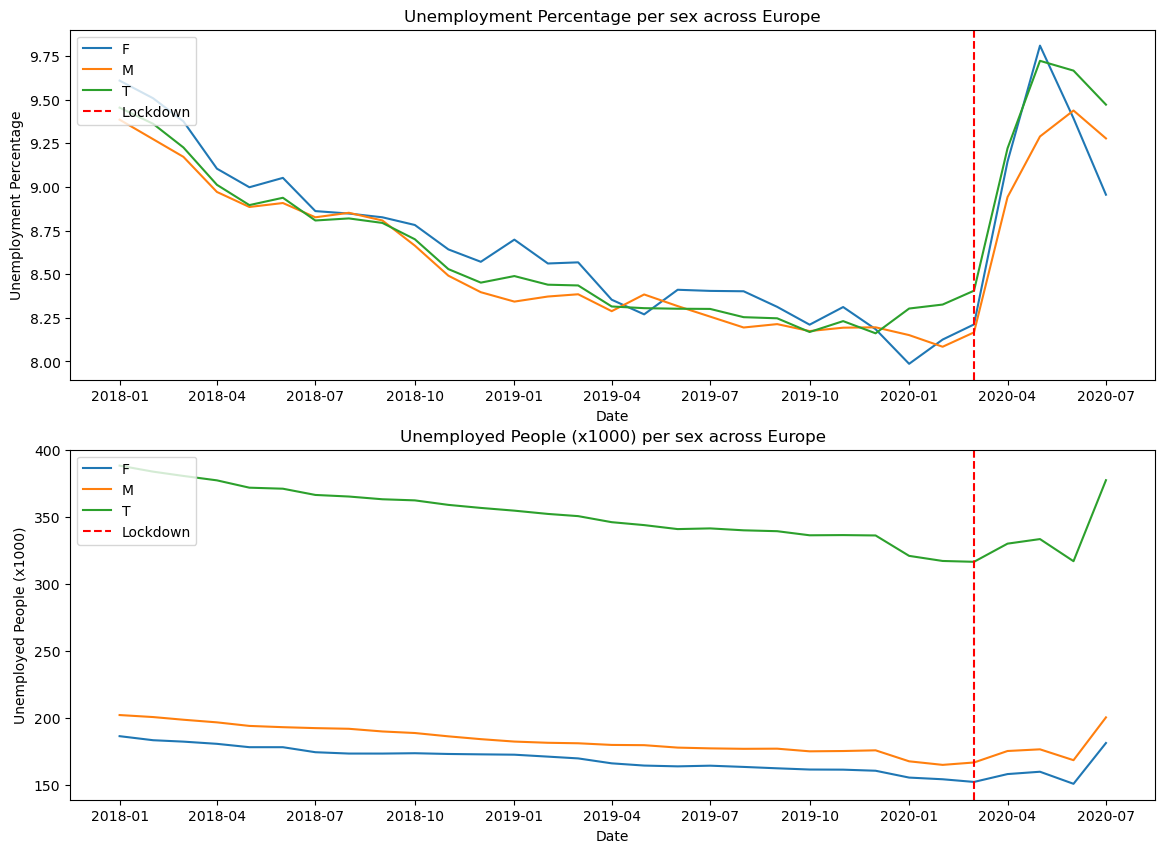

In [160]:
res_sex=unemployment_across_groups(dfts,'sex',(14,10))

## Distribution amongst Countries

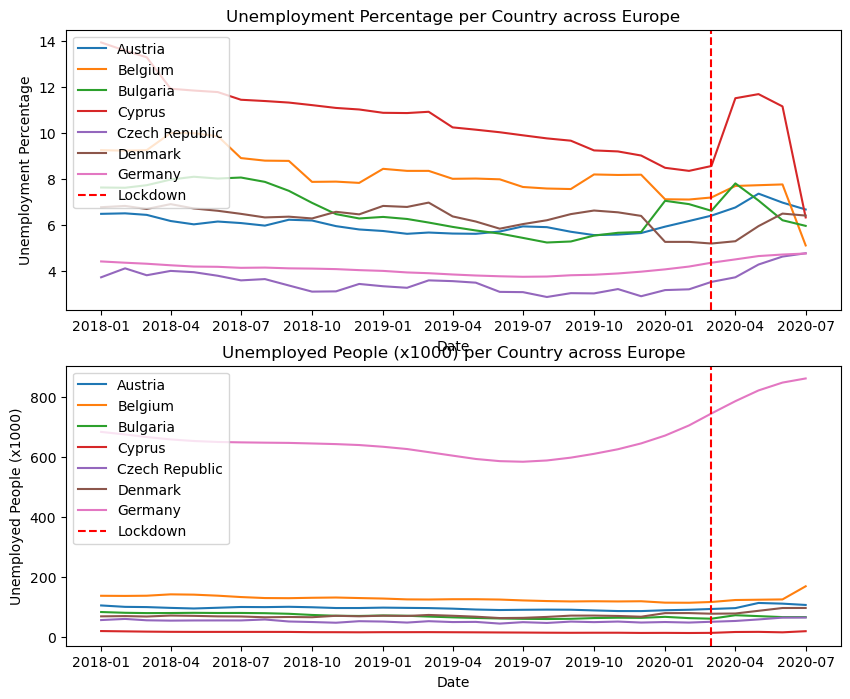

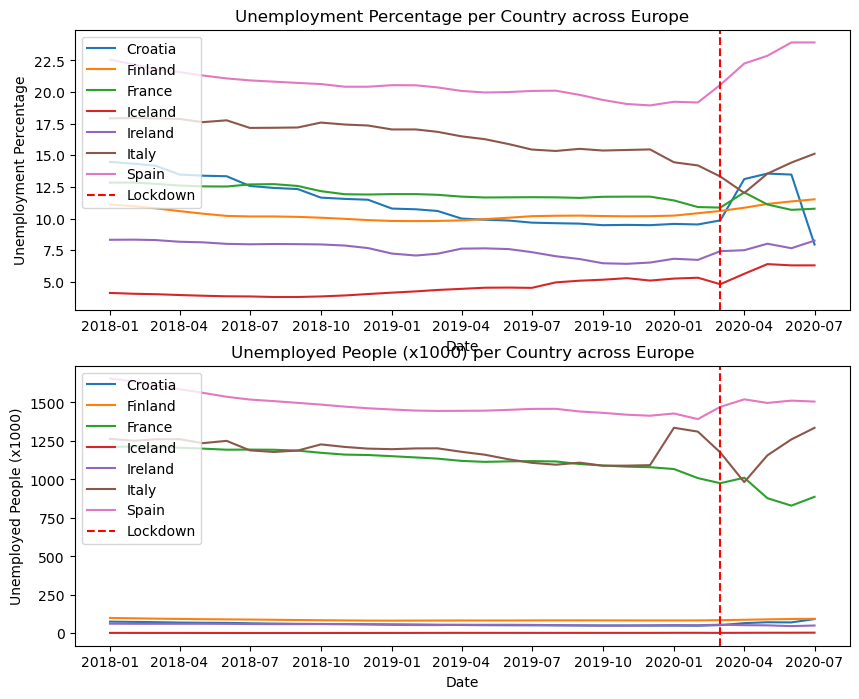

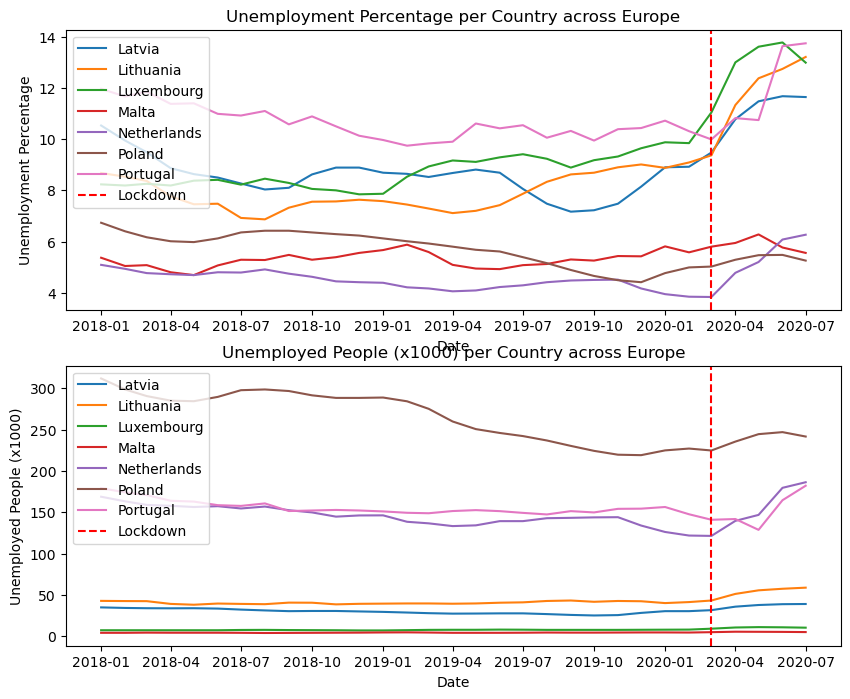

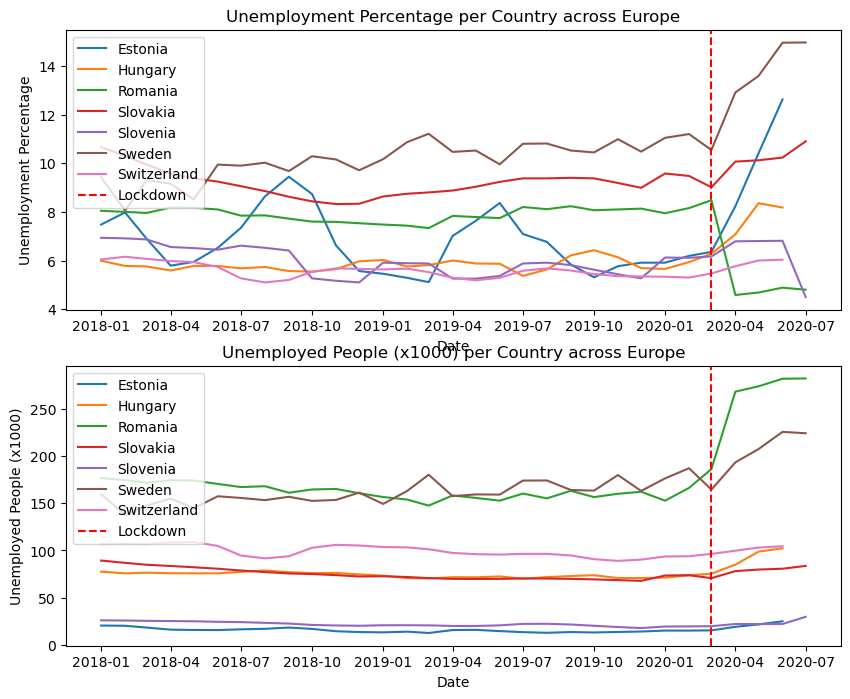

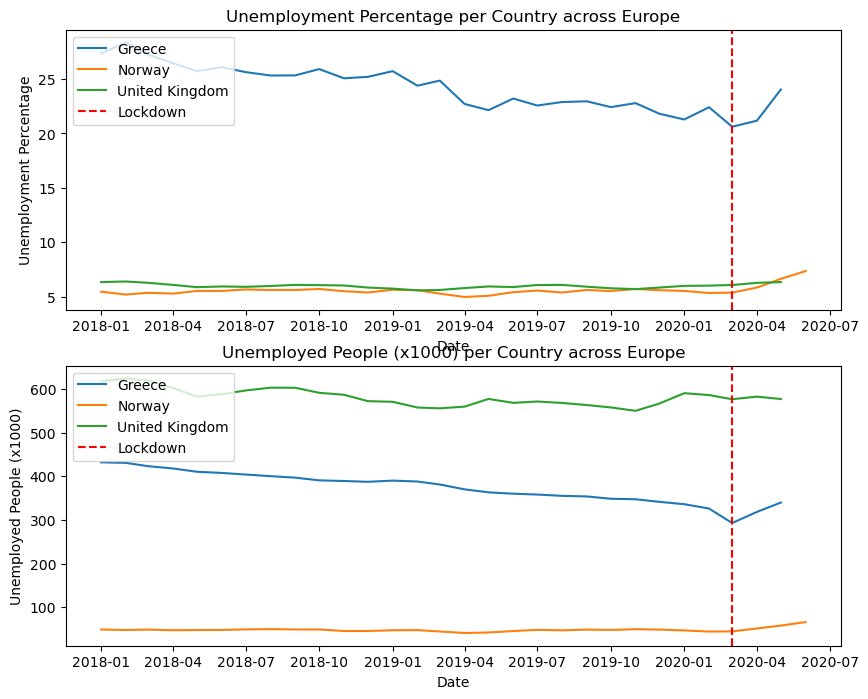

In [161]:
splits=np.split((dfts['Country'].unique())[:-3],4)
splits.append(dfts['Country'].unique()[-3:])
dfs_country=[dfts[dfts['Country'].isin(s)] for s in splits]
res_country=[]
for df_country in dfs_country:
    r_group=unemployment_across_groups(df_country,'Country',size=(10,8))
    res_country.append(r_group)

## TO DO
- ask nico wag1 with the units
- look into a treatment and control centric approach to this case study
- regress